In [549]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize 
from sklearn.metrics import f1_score
import math
from sklearn import svm as imsvm
from scipy.optimize import fsolve
from itertools import chain, count, islice
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.utils import check_array, check_random_state
from itertools import product
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import scipy as sp

In [550]:
linear = lambda x, y: np.squeeze(np.inner(x, y))
def gauss(sigm):
#     x1, x2 = x
#     y1, y2 = y
#     x = [x1 ** 2 + x2 ** 2, math.atan2(x2, x1)]
#     y = [x1 ** 2 + x2 ** 2, math.atan2(x2, x1)]
    return lambda x, y: np.squeeze(np.exp(-np.square(np.linalg.norm(x - y, axis=-1)) / sigm))

In [551]:
class SVM:
    def __init__(self, kernel=('linear', 0.1), C=1.,):
        if kernel[0] == 'linear':
            self.kernel = linear
        elif kernel[0] == 'gauss':
            self.kernel = gauss(kernel[1])
        self.C = C
            
    def fit(self, X, y):
#         X = X[:, np.newaxis, ...]
        n = len(y)
        self.X = X
        self.y = y
        
        Q = self.kernel(X[:, np.newaxis, ...], X[np.newaxis, ...])        
        y1 = y[:, np.newaxis]
        Q = y1.dot(y1.T) * Q / 2

        def tomin(lambdas):
            res = lambdas.T.dot(Q).dot(lambdas)
            res -= lambdas.sum(axis = 0)
            return res
        
        
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.inner(y, x)},
            {'type': 'ineq', 'fun': lambda x: x},
            {'type': 'ineq', 'fun': lambda x: self.C - x}
        )
        startx = np.random.rand(n) * self.C
        lambda_res = minimize(fun=tomin, x0=startx, constraints=constraints)
#         constraints = (
#             {'type': 'eq', 'fun': lambda x: np.inner(y, x)}
#         )
#         startx = np.random.rand(n) * self.C
#         lambda_res = minimize(fun=tomin, x0=startx, constraints=constraints
#                               , bounds = [(0, self.C)] * n
#                               , method = 'SLSQP')
        self.lambdas = lambda_res.x
        
        self.c = np.median(Q.dot(self.lambdas * y) - y)

    def predict(self, X):
        X = X[np.newaxis, ...]
#         print(X[0])
        KK = self.kernel(self.X[np.newaxis, ...], X[:, np.newaxis, ...])
        pred = KK.dot(self.lambdas * self.y) - self.c
        return (pred > 0) * 2 - 1

In [552]:
def gen(n):
    x = np.random.rand(n, 2) * 2 - 1
    y = np.array([int(xx[1] > 0) * 2 - 1 for xx in x])
    return x, y

In [553]:
def load(fname):
    with open(fname) as fin:
        data = np.array([list(map(float, s[:-1].split(','))) for s in fin.readlines()])
        return data.T[:-1].T, data.T[-1].T * 2 - 1

In [554]:
X, Y = load('chips.txt')

In [555]:
X.T[0] -= np.mean(X.T[0])
X.T[0] /= np.std(X.T[0])
X.T[1] -= np.mean(X.T[1])
X.T[1] /= np.std(X.T[1])

In [556]:
cl = SVM(kernel=('gauss', 0.1), C = 11)
cl.fit(X, Y)

In [557]:
set([cl.predict(x[np.newaxis, ...]) for x in X])

{-1, 1}

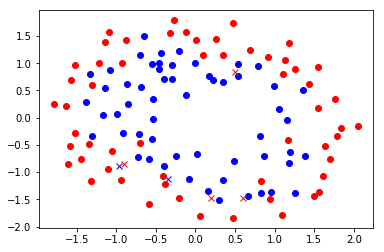

In [558]:
for x, y in zip(X, Y):
    y_pr = cl.predict(x)
    c = 'b' if y > 0 else 'r'
    s = 'o' if y_pr == y else 'x'
    plt.plot(x[0], x[1], s + c)
plt.show()

In [559]:
f1_score(Y, [cl.predict(x[np.newaxis, ...]) for x in X])

0.94915254237288149

In [560]:
def cross_validate(model, xy_folds, Q):
    cv = 0
    for x_train, y_train, x_test, y_test in xy_folds:
        model.fit(x_train, y_train)
        y_pred = np.array([model.predict(x) for x in x_test])
        cv += Q(y_test, y_pred) / len(xy_folds)
    return cv

In [561]:
class GridSearch:
    def __init__(self, model, Q, params, t, k):
        self.model = model
        self.params = params
        self.Q = Q
        self.k = k
        self.t = t
    
    def fit(self, X, y):
        global xy_folds
        pkeys = self.params.keys()
        pvalues = list(product(*self.params.values()))
        res = []
        
        xy_folds = []
        k = self.k
        
        inds = np.arange(len(X))
        np.random.shuffle(inds)
        Xk = X[inds]
        yk = y[inds]
            
        for i in range(k):
            l = math.ceil(i * len(X) / self.k)
            if i == k - 1:
                r = len(X)
            else:
                r = math.ceil((i + 1) * len(X) / self.k)
            x_train = np.append(Xk[:l], Xk[r:], axis = 0)
            y_train = np.append(yk[:l], yk[r:], axis = 0)
            x_test = Xk[l:r]
            y_test = yk[l:r]
#             print(list(map(len, [x_train, y_train, x_test, y_test])))

            xy_folds.append((x_train, y_train, x_test, y_test))
        
        for v in pvalues:
            local_ps = dict(zip(pkeys, v))
            print(local_ps)
            res.append((cross_validate(self.model(**local_ps), xy_folds, self.Q), local_ps))
        
        minv = 1e10
        for cv, ps in res:
            if cv < minv:
                minv = cv
                self.best_params = ps
                self.best_error = cv
        return res

In [583]:
params = {
    'kernel' : [('gauss', a) for a in np.arange(0.24, 0.26, 0.02)],
    'C' : np.arange(5, 7, 1)
}

In [618]:
K = 10

In [634]:
gs = GridSearch(SVM, lambda y_true, y_pred: 1 - f1_score(y_true, y_pred), params, 0, K)
res = gs.fit(X, Y)

{'kernel': ('gauss', 0.23999999999999999), 'C': 5}


c:\python\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


{'kernel': ('gauss', 0.23999999999999999), 'C': 6}
{'kernel': ('gauss', 0.26000000000000001), 'C': 5}
{'kernel': ('gauss', 0.26000000000000001), 'C': 6}


In [635]:
print('Best params:', gs.best_params)
print('f1:', 1 - gs.best_error)
svm_params = gs.best_params

Best params: {'kernel': ('gauss', 0.26000000000000001), 'C': 5}
f1: 0.66201931883


In [ ]:
knn.predict()

In [636]:
svm = SVM(**gs.best_params)
svm.fit(X, Y)

In [637]:
f1_score(Y, [svm.predict(x[np.newaxis, ...]) for x in X])

0.90625

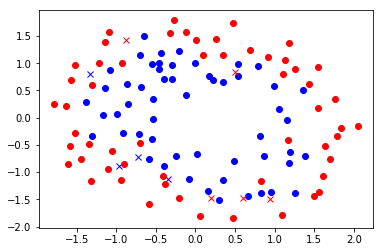

In [638]:
for x, y in zip(X, Y):
    y_pr = cl.predict(x)
    c = 'b' if y > 0 else 'r'
    s = 'o' if y_pr == y else 'x'
    plt.plot(x[0], x[1], s + c)
plt.show()

In [639]:
knn = KNeighborsClassifier()

In [640]:
knn_params = {
    'n_neighbors' : list(range(4, 13)),
    'p' : [2,3,4]
}
gs = GridSearchCV(knn, knn_params, scoring='f1')
gs.fit(X, Y)

GridSearchCV(cv=None, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_neighbors': [4, 5, 6, 7, 8, 9, 10, 11, 12], 'p': [2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

In [641]:
knn = gs.best_estimator_

In [642]:
svmf1s = np.zeros((K,))
knnf1s = np.zeros((K,))

In [643]:
i = 0
for x_train, y_train, x_test, y_test in xy_folds:
    knn.fit(x_train, y_train)
    cl.fit(x_train, y_train)
    knnf1s[i] = f1_score(y_test, knn.predict(x_test))
    svmf1s[i] = f1_score(y_test, [cl.predict(x) for x in x_test])
    i += 1

In [644]:
print(svmf1s)
print(knnf1s)

[ 0.54545455  0.6         0.76923077  0.61538462  0.          0.46153846
  0.70588235  0.71428571  0.54545455  0.85714286]
[ 0.66666667  0.75        0.28571429  0.5         0.4         0.36363636
  0.875       0.76923077  0.54545455  0.90909091]


In [645]:
signs = svmf1s - knnf1s
diffs = np.abs(svmf1s - knnf1s)[signs != 0]
signs = signs[signs != 0]

In [649]:
almost_rangs = np.argsort(diffs) + 1
rp = np.sum((signs > 0) * almost_rangs)
rm = np.sum((signs < 0) * almost_rangs)
print(min(rp, rm))

12


In [647]:
N = len(signs)
x = (min(rp, rm) - N * (N + 1) * 0.25) / np.sqrt(N * (N + 1) * (2 * N + 1) / 24)

In [648]:
pval = sp.stats.norm.sf(abs(x))
print('p-value ', pval)

p-value  0.106762177018
